# Project: Koopman Operator eigenfunctions reveal geometry of optimisation

## Objective
Consider the ellipsoidal quadratic function
$$f(x_1, x_2) = \lambda_1 x_1^2 + \lambda_2 x_2^2, \quad \lambda_1,\lambda_2>0$$
where $x=(x_1,x_2)^\top\in\mathbb{R}^2$. The goal is to study and compare the behavior of *Gradient Descent (GD)* and *Heavy-Ball momentum (HB)* optimisation methods as discrete-time dynamical systems.

## Basic properties of $f$
* The function $f$ is convex and has a unique global minimiser:
$$x^*=(0,0)^\top, \quad f(x^*)=0.$$
* The gradient and Hessian are:
$$\nabla f(x) = \left(\begin{array}{c}
2\lambda_1 x_1\\
2\lambda_2 x_2\\
\end{array}\right), \quad \nabla^2 f(x) = \left(\begin{array}{cc}
2\lambda_1 & 0\\
0 & 2\lambda_2\\ 
\end{array}\right).$$
* The Lipschitz constant of the gradient is:
$$ L = 2\max(\lambda_1, \lambda_2).$$

## Part A: Gradient descent as a dynamical system
Gradient descent with step size $\alpha > 0$ is defined by:
$$x_{k+1}=x_k - \alpha\nabla f(x_k).$$

For this quadratic,
$$x_{k+1} = \left(\begin{array}{cc}
1-2\alpha\lambda_1 & 0\\
0 & 1-2\alpha\lambda_2\\ 
\end{array}\right)x_k.$$

#### a) Derive the closed-form iterates $x_{1,k}$, $x_{2,k}$ in terms of $x_0$.
$x_{1,k} = (1-2\alpha\lambda_1)^k x_{1,0}$

$x_{2,k} = (1-2\alpha\lambda_2)^k x_{2,0}$

#### b) Derive the eigenfunctions and eigenvalues of the system.

Right eigenvectors:

$(1,0)^\top, (0,1)^\top$

Eigenfunctions:

$\phi_1(x)=(1,0) x = x_1,\quad \lambda=1-2\alpha\lambda_1$

$\phi_2(x)=(0,1) x = x_2,\quad \lambda=1-2\alpha\lambda_2$

and all the associated powers.

#### c) Determine conditions on $\alpha$ for convergence $x_k\to 0$.

A discrete system will converge when eigenvalues are $0<\lambda<1$. So here, we need $1 - 2 \alpha \lambda_{1,2} < 1,$ meaning $0 < \lambda_{1,2} < \frac{1}{2\alpha}.$ 

#### d) Explain why, when $\lambda_1 \ll\lambda_2$, the convergence is slow along the $x_1$-direction.

$\lambda_1 \ll\lambda_2$ means the eigenvalue associated with $\phi_1$ is much closer to 1 than the eigenvalue associated with $\phi_2$. Because the eigenfunctions are associated with the bare coordinate direcitons ($\phi_1(x)=x_1$ and $\phi_2(x)=x_2$), this means $x_1$ will decay to zero much more slowly than $x_2$.

#### e) (Visualisation) Plot GD trajectories from multiple initial conditions in $\mathbb{R}^2$ over level sets of $f$ and "slow" isostables associated with the "slow" eigenvalue.

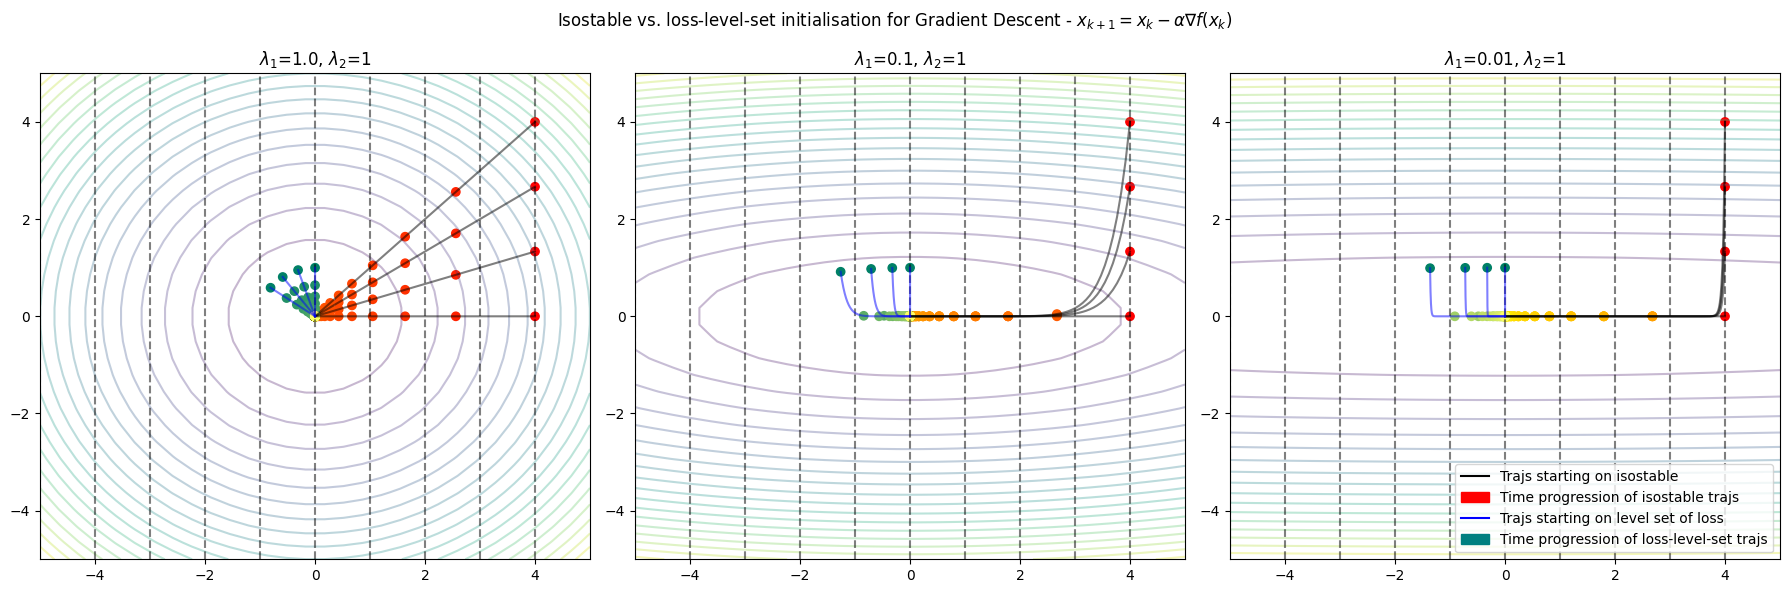

In [277]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
# from scipy.integrate import solve_ivp


def f(X, l1, l2):
    x1, x2 = X
    return l1 * x1**2 + l2 * x2**2


def grad_f(X, l1, l2):
    x1, x2 = X
    return np.array([2 * l1 * x1, 2 * l2 * x2]).T


def grad_descent(X, grad_f, l1, l2, alpha=0.1):
    return X - alpha * grad_f(X, l1=l1, l2=l2)


fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, l1 in enumerate([1e0, 1e-1, 1e-2]):
    ax = axes[i]
    alpha, l2 = 0.1, 1

    ## Level sets of loss
    step = 1
    x1_grid = np.linspace(-5, 5, 30)
    x2_grid = np.linspace(-5, 5, 30)
    X1, X2 = np.meshgrid(x1_grid, x2_grid)
    Loss = np.zeros_like(X1)
    for i in range(0, X1.shape[0], step):
        for j in range(0, X2.shape[1], step):
            X = X1[i, j], X2[i, j]
            Loss[i, j] = f(X, l1=l1, l2=l2)
    ax.contour(X1, X2, Loss, 20, cmap="viridis", alpha=0.3)

    ## Isostables, here φ_2 when λ_1 << λ_2
    for x in range(-5, 5):
        ax.plot([x, x], [-5, 5], "k--", alpha=0.5)

    ## Trajectories starting on isostable
    n_timesteps = 5000
    skip_step = int(2 / l1)
    xs = np.linspace(0, 4, 4)
    X0s = [np.array([4, x]).T for x in xs]  # for y in xs]
    for X0 in X0s:
        Xs = [X0]
        for t in range(n_timesteps - 1):
            Xt = grad_descent(Xs[-1], grad_f, l1=l1, l2=l2, alpha=alpha)
            Xs.append(Xt)
            # print(Xt)
        Xs = np.array(Xs)
        ax.plot(Xs[:, 0], Xs[:, 1], c="k", alpha=0.5)
        ax.scatter(
            Xs[::skip_step, 0],
            Xs[::skip_step, 1],
            c=[np.log(x / n_timesteps) for x in range(1, n_timesteps + 1, skip_step)],
            cmap="autumn",
        )

    ## Trajectories starting on level set of loss
    thetas = np.linspace(np.pi / 2, 0.8 * np.pi, 4)
    X0s = [
        np.array(
            [
                np.sqrt(1 / (l1 * np.cos(theta) ** 2 + l2 * np.sin(theta) ** 2))
                * np.cos(theta),
                np.sqrt(1 / (l1 * np.cos(theta) ** 2 + l2 * np.sin(theta) ** 2))
                * np.sin(theta),
            ]
        ).T
        for theta in thetas
    ]
    for X0 in X0s:
        Xs = [X0]
        for t in range(n_timesteps - 1):
            Xt = grad_descent(Xs[-1], grad_f, l1=l1, l2=l2, alpha=alpha)
            Xs.append(Xt)
        Xs = np.array(Xs)
        ax.plot(Xs[:, 0], Xs[:, 1], c="b", alpha=0.5)
        ax.scatter(
            Xs[::skip_step, 0],
            Xs[::skip_step, 1],
            c=[np.log(x / n_timesteps) for x in range(1, n_timesteps + 1, skip_step)],
            cmap="summer",
        )

    ax.set_xlim((-5, 5))
    ax.set_ylim((-5, 5))
    ax.set_title(f"$λ_1$={l1}, $λ_2$={l2}")

iso_line = Line2D([0], [0], label="Trajs starting on isostable", c="k")
iso_patch = mpatches.Patch(color="red", label="Time progression of isostable trajs")
ls_line = Line2D([0], [0], label="Trajs starting on level set of loss", c="b")
ls_patch = mpatches.Patch(
    color="teal", label="Time progression of loss-level-set trajs"
)
plt.legend(handles=[iso_line, iso_patch, ls_line, ls_patch], loc="lower right")

plt.suptitle(
    "Isostable vs. loss-level-set initialisation for Gradient Descent - $x_{k+1} = x_k - α\\nabla f(x_k)$"
)
plt.tight_layout()
plt.show()


In [439]:
from matplotlib.animation import FuncAnimation

XMIN, XMAX = -4, 4
YMIN, YMAX = -4, 4

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
all_trajs = []
for i, l1 in enumerate([1e0, 1e-1, 1e-2]):
    ax = axes[i]

    ax.set_xlim(XMIN, YMAX)
    ax.set_ylim(YMIN, YMAX)
    ax.set_aspect("equal")
    ax.set_title(f"$λ_1$={l1}, $λ_2$={l2}")

    ## FIXED POINT
    ax.plot(0, 0, "ro", markersize=6)

    ## ISOSTABLE LEVEL SETS
    def phi(x, v):
        w = np.array([1, 0])
        return x * w[0] + v * w[1]

    # print("ISOSTABLE", evals, slow_eval, w)
    step = 1
    x1_grid = np.linspace(XMIN, XMAX, 30)
    x2_grid = np.linspace(YMIN, YMAX, 30)
    X1, X2 = np.meshgrid(x1_grid, x2_grid)
    Isostable = np.zeros_like(X1)
    for i in range(0, X1.shape[0], step):
        for j in range(0, X2.shape[1], step):
            x1, x2 = X1[i, j], X2[i, j]
            Isostable[i, j] = phi(x1, x2)
    ax.contour(X1, X2, Isostable, 20, cmap="viridis", alpha=0.3)


    c = 3
    CS = plt.contour(X1, X2, Isostable, levels=[c], alpha=0) 
    # print(CS.allsegs)
    all_points_on_level_set = []
    for segment in CS.allsegs[0]: # allsegs[0] contains all segments for the first (and in this case, only) level
        for point in segment:
            all_points_on_level_set.append(point)

    points_array = np.array(all_points_on_level_set)

    ## TRAJECTORIES
    T = 25.0
    frames = 100
    t_eval = np.linspace(0, T, frames)
    # print(t_eval.shape)
    # break

    trajectories = []
    for i in range(0, len(points_array), 5):
        Xs = [points_array[i]]
        for t in range(n_timesteps - 1):
            Xt = grad_descent(Xs[-1], grad_f, l1=l1, l2=l2, alpha=alpha)
            Xs.append(Xt)
        Xs = np.array(Xs)
        # print(s0)
        trajectories.append(Xs)

    all_trajs.append(trajectories)

all_points = [ax.scatter([], [], s=25, c="black") for ax in axes]
def update(frame):
    for points, trajectories in zip(all_points, all_trajs):
        xs = [traj[frame, 0] for traj in trajectories]
        ys = [traj[frame, 1] for traj in trajectories]
        points.set_offsets(np.column_stack([xs, ys]))
    return all_points


ani = FuncAnimation(fig, update, frames=frames, interval=100, blit=True)
plt.suptitle("Gradient descent trajectories starting on isostable")
plt.tight_layout()
ani.save("quad-loss-grad-desc_isostable_convergence.gif", writer="pillow", fps=40)
plt.close()

### Natural gradient descent

$$\dot\theta = -G^{-1}\nabla L(\theta)$$

$$x_{k+1} = x_k - \alpha G^{-1}(x_k)\nabla L(x_k)$$

$$G^{-1} = (\nabla^2 f(x))^{-1} = \left(\begin{array}{cc}
\frac{1}{2\lambda_1} & 0\\
0 & \frac{1}{2\lambda_2}\\ 
\end{array}\right)$$

$$x_{k+1} = x_k - \alpha (\nabla^2 f(x))^{-1}\nabla L(x_k) = x_k - \alpha\left(\begin{array}{cc}
\frac{1}{2\lambda_1} & 0\\
0 & \frac{1}{2\lambda_2}\\ 
\end{array}\right) \left(\begin{array}{c}
2\lambda_1 x_1\\
2\lambda_2 x_2\\
\end{array}\right) = (1-\alpha)x_k$$

Eigenvalues: $(1-\alpha)$
Eigenfunctions: phi=x1, phi=x2

Natural gradient descent turns isostable into loss level set???? By warping the ellipse back into a circle & treating space as spherical. 

Every coordinate system seems to decay with the same rate? Isotropic?

Natural gradient descent REMOVES isostable...

landscape is perfectly round → no slow direction → infinitely many isostables.

uniform contraction only true when metric is constant.

Okay, a lot of this stuff is probably only true near a minimum where you can taylor expand and behave as if things are quadratic.
NGD = Euclidean gradient descent in Fisher Coordinates

Isostables satisfy pde?
∇ϕ⋅F−1∇L=λϕ.

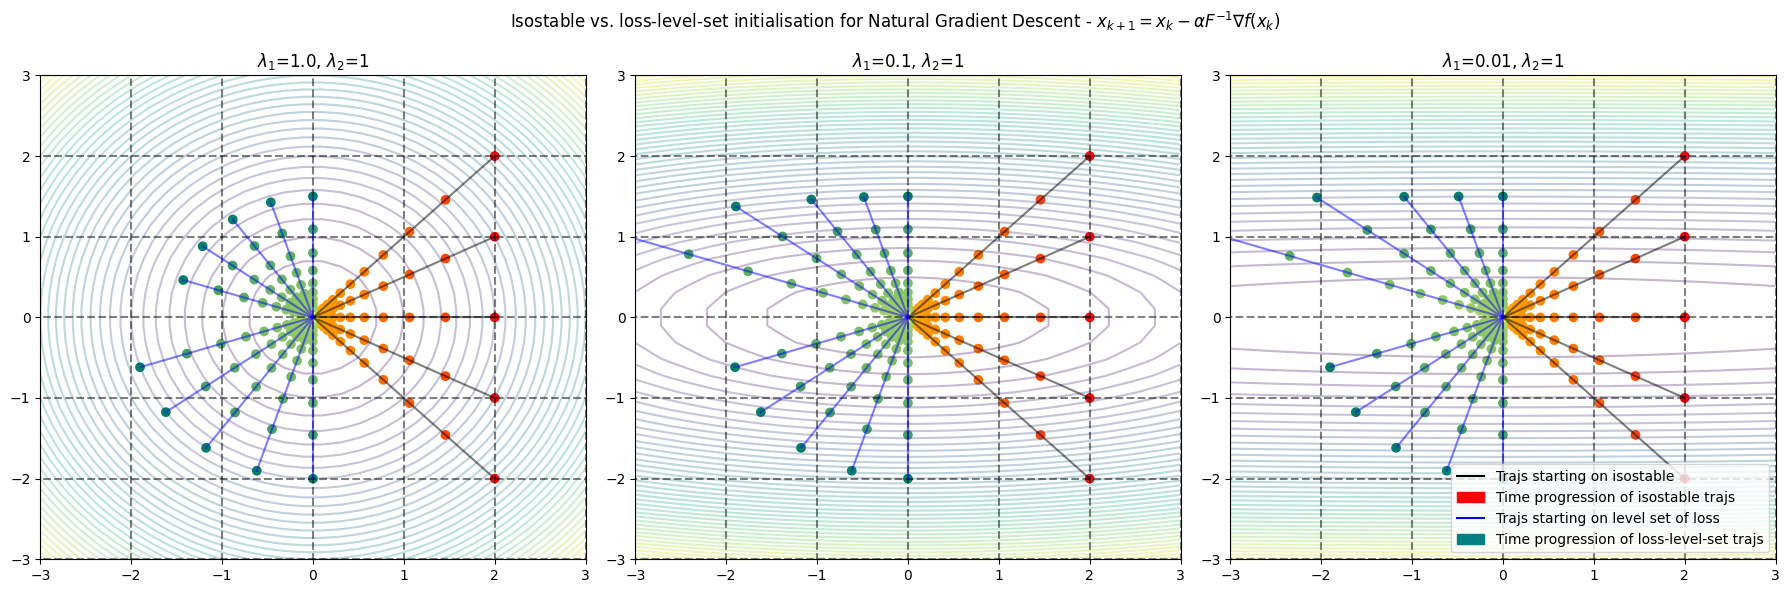

In [419]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
# from scipy.integrate import solve_ivp

def nat_grad_descent(X, alpha=0.1):
    return X - alpha * X

XMIN, XMAX = -3, 3
YMIN, YMAX = -3, 3

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, l1 in enumerate([1e0, 1e-1, 1e-2]):
    ax = axes[i]
    alpha, l2 = 0.1, 1

    ## Level sets of loss
    step = 1
    x1_grid = np.linspace(XMIN, XMAX, 30)
    x2_grid = np.linspace(YMIN, YMAX, 30)
    X1, X2 = np.meshgrid(x1_grid, x2_grid)
    Loss = np.zeros_like(X1)
    for i in range(0, X1.shape[0], step):
        for j in range(0, X2.shape[1], step):
            X = X1[i, j], X2[i, j]
            Loss[i, j] = f(X, l1=l1, l2=l2)
    ax.contour(X1, X2, Loss, 40, cmap="viridis", alpha=0.3)

    ## Isostable is phi=r
    theta = np.linspace(0, 2 * np.pi, 100) # 100 points for a smooth circle
    for r in range(-5, 5):
        # ax.plot(r*np.cos(theta), r*np.sin(theta), "k--", alpha=0.5)
        ax.plot([-5, 5], [r, r], "k--", alpha=0.5)
        ax.plot([r, r], [-5, 5], "k--", alpha=0.5)

    ## Trajectories starting on isostable
    n_timesteps = 200
    skip_step = 3
    xs = np.linspace(-2, 2, 5)
    X0s = [np.array([2, x]).T for x in xs]  # for y in xs]
    for X0 in X0s:
        Xs = [X0]
        for t in range(n_timesteps - 1):
            Xt = nat_grad_descent(Xs[-1], alpha=alpha)
            Xs.append(Xt)
            # print(Xt)
        Xs = np.array(Xs)
        ax.plot(Xs[:, 0], Xs[:, 1], c="k", alpha=0.5)
        ax.scatter(
            Xs[::skip_step, 0],
            Xs[::skip_step, 1],
            c=[np.log(x / n_timesteps) for x in range(1, n_timesteps + 1, skip_step)],
            cmap="autumn",
        )

    ## Trajectories starting on level set of loss
    thetas = np.linspace(np.pi / 2, 0.9 * np.pi, 5)
    X0s = [
        1.5 * np.array(
            [
                np.sqrt(1 / (l1 * np.cos(theta) ** 2 + l2 * np.sin(theta) ** 2))
                * np.cos(theta),
                np.sqrt(1 / (l1 * np.cos(theta) ** 2 + l2 * np.sin(theta) ** 2))
                * np.sin(theta),
            ]
        ).T
        for theta in thetas
    ]
    X0s.extend([
        2 * np.array(
            [
                np.cos(theta),
                np.sin(theta),
            ]
        ).T
        for theta in np.linspace(1.1 * np.pi,3* np.pi / 2,  5)
    ])
    for X0 in X0s:
        Xs = [X0]
        for t in range(n_timesteps - 1):
            Xt = nat_grad_descent(Xs[-1], alpha=alpha)
            Xs.append(Xt)
        Xs = np.array(Xs)
        ax.plot(Xs[:, 0], Xs[:, 1], c="b", alpha=0.5)
        ax.scatter(
            Xs[::skip_step, 0],
            Xs[::skip_step, 1],
            c=[np.log(x / n_timesteps) for x in range(1, n_timesteps + 1, skip_step)],
            cmap="summer",
        )

    ax.set_xlim((XMIN, XMAX))
    ax.set_ylim((YMIN, YMAX))
    ax.set_title(f"$λ_1$={l1}, $λ_2$={l2}")

iso_line = Line2D([0], [0], label="Trajs starting on isostable", c="k")
iso_patch = mpatches.Patch(color="red", label="Time progression of isostable trajs")
ls_line = Line2D([0], [0], label="Trajs starting on level set of loss", c="b")
ls_patch = mpatches.Patch(
    color="teal", label="Time progression of loss-level-set trajs"
)
plt.legend(handles=[iso_line, iso_patch, ls_line, ls_patch], loc="lower right")

plt.suptitle(
    "Isostable vs. loss-level-set initialisation for Natural Gradient Descent - $x_{k+1} = x_k - αF^{-1}\\nabla f(x_k)$"
)
plt.tight_layout()
plt.show()


## Part B: Heavy-Ball momentum as a 4D dynamical system

The heavy-ball method introduces a momentum variable $v_k\in\mathbb{R}^2$ and is defined by:
$$v_{k+1} = \beta v_k - \alpha\nabla f(x_k), \quad x_{k+1} = x_k + v_{k+1}, \quad\alpha>0, \beta\in(0,1).$$

Define the augmented state $s_k=(x_k,v_k)\in\mathbb{R}^4$. Show that the heavy-ball update can be written as the linear dynamical system:
$$\left(\begin{array}{c}
x_{k+1}\\
v_{k+1}\\ 
\end{array}\right) = \left(\begin{array}{cc}
I-2\alpha\Lambda & \beta I\\
-2\alpha\Lambda & \beta I\\ 
\end{array}\right)\left(\begin{array}{c}
x_{k}\\
v_{k}\\ 
\end{array}\right), \quad \Lambda = \operatorname{diag}(\lambda_1, \lambda_2).$$

#### a) Show that the dynamics decouple into two independent $2\times 2$ subsystems for $(x_1, v_1)$ and $(x_2, v_2)$.

The dynamical system above gives the following updates for $i\in\{1,2\}$:

$x_i' = (1-2\alpha\lambda_i)x_i + \beta v_i'$

$v_i' = -2\alpha\lambda_i x_i + \beta v_i$

This shows no interdependence between the two $i$ levels.

#### b) For each coordinate $i\in\{1,2\}$, derive the characteristic polynomial and eigenvalues of the block matrix
$$A_i=\left(\begin{array}{cc}
1-2\alpha\lambda_i & \beta\\
-2\alpha\lambda_i & \beta\\ 
\end{array}\right).$$

Let's make eigenvalues $\sigma$ to avoid confusion.

$\operatorname{det}(A_i - \sigma I) = (1-2\alpha\lambda_i - \sigma) * (\beta-\sigma) + 2\alpha\lambda_i * \beta = 0$

$\sigma^2 - (1-2\alpha\lambda_i+\beta)\sigma + \beta = 0$

$\sigma_\pm = \frac{1}{2} (1-2\alpha\lambda_i+\beta\pm\sqrt{(1-2\alpha\lambda_i+\beta)^2-4\beta})$

Or, for something prettier, set $c=1-2\alpha\lambda_i+\beta$. This makes $\sigma_\pm = \frac{1}{2} ( c \pm \sqrt{c^2-4\beta})$

#### c) Compute the eigenfunctions of the system.

Eigenvectors: 

$0=(1-2\alpha\lambda_i-\sigma_+)u_1 + \beta u_2$

$ u_2 = \frac{\sigma_++2\alpha\lambda_i-1}{\beta} u_1$

<!-- $0=-2\alpha\lambda_i u_1 + (\beta-\sigma_+) u_2$

$0=-2\alpha\lambda_i u_1 + \frac{(\sigma_++2\alpha\lambda_i-1)(\beta-\sigma_+)}{\beta} u_1 = \frac{-2\alpha\lambda_i\beta + (\sigma_++2\alpha\lambda_i-1)(\beta-\sigma_+)}{\beta} u_1$ -->

$u_\pm = \left(\begin{array}{c}
\beta\\
\sigma_\pm+2\alpha\lambda_i-1\\ 
\end{array}\right).$

Since the system is linear, Koopman eigenfunctions are also linear.

$$\phi(s) = w^\top s = (\sigma_\pm - \beta)x + \beta v$$

#### d) Discuss how choices of $(\alpha, \beta)$ can reduce the effective slow contraction associated with $\lambda_1$.

#### e) (Visualisation) Plot HB trajectories in x-space over level sets of $f$ and projection of level sets of the slow isostable and compare with GD for the same initial points.

#### f) (Visualisation) Plot trajectories in the phase plane $(x_1, v_1)$ over the slow isostable.

In [323]:
def eigenvalues(a, b, l):
    c = 1 - 2 * a * l + b
    det = np.sqrt(c**2 - 4 * b)
    return 0.5 * (c + det), 0.5 * (c - det)


eigenvalues(1, 0.02, 0.1)

(np.float64(0.7948376280978773), np.float64(0.025162371902122838))

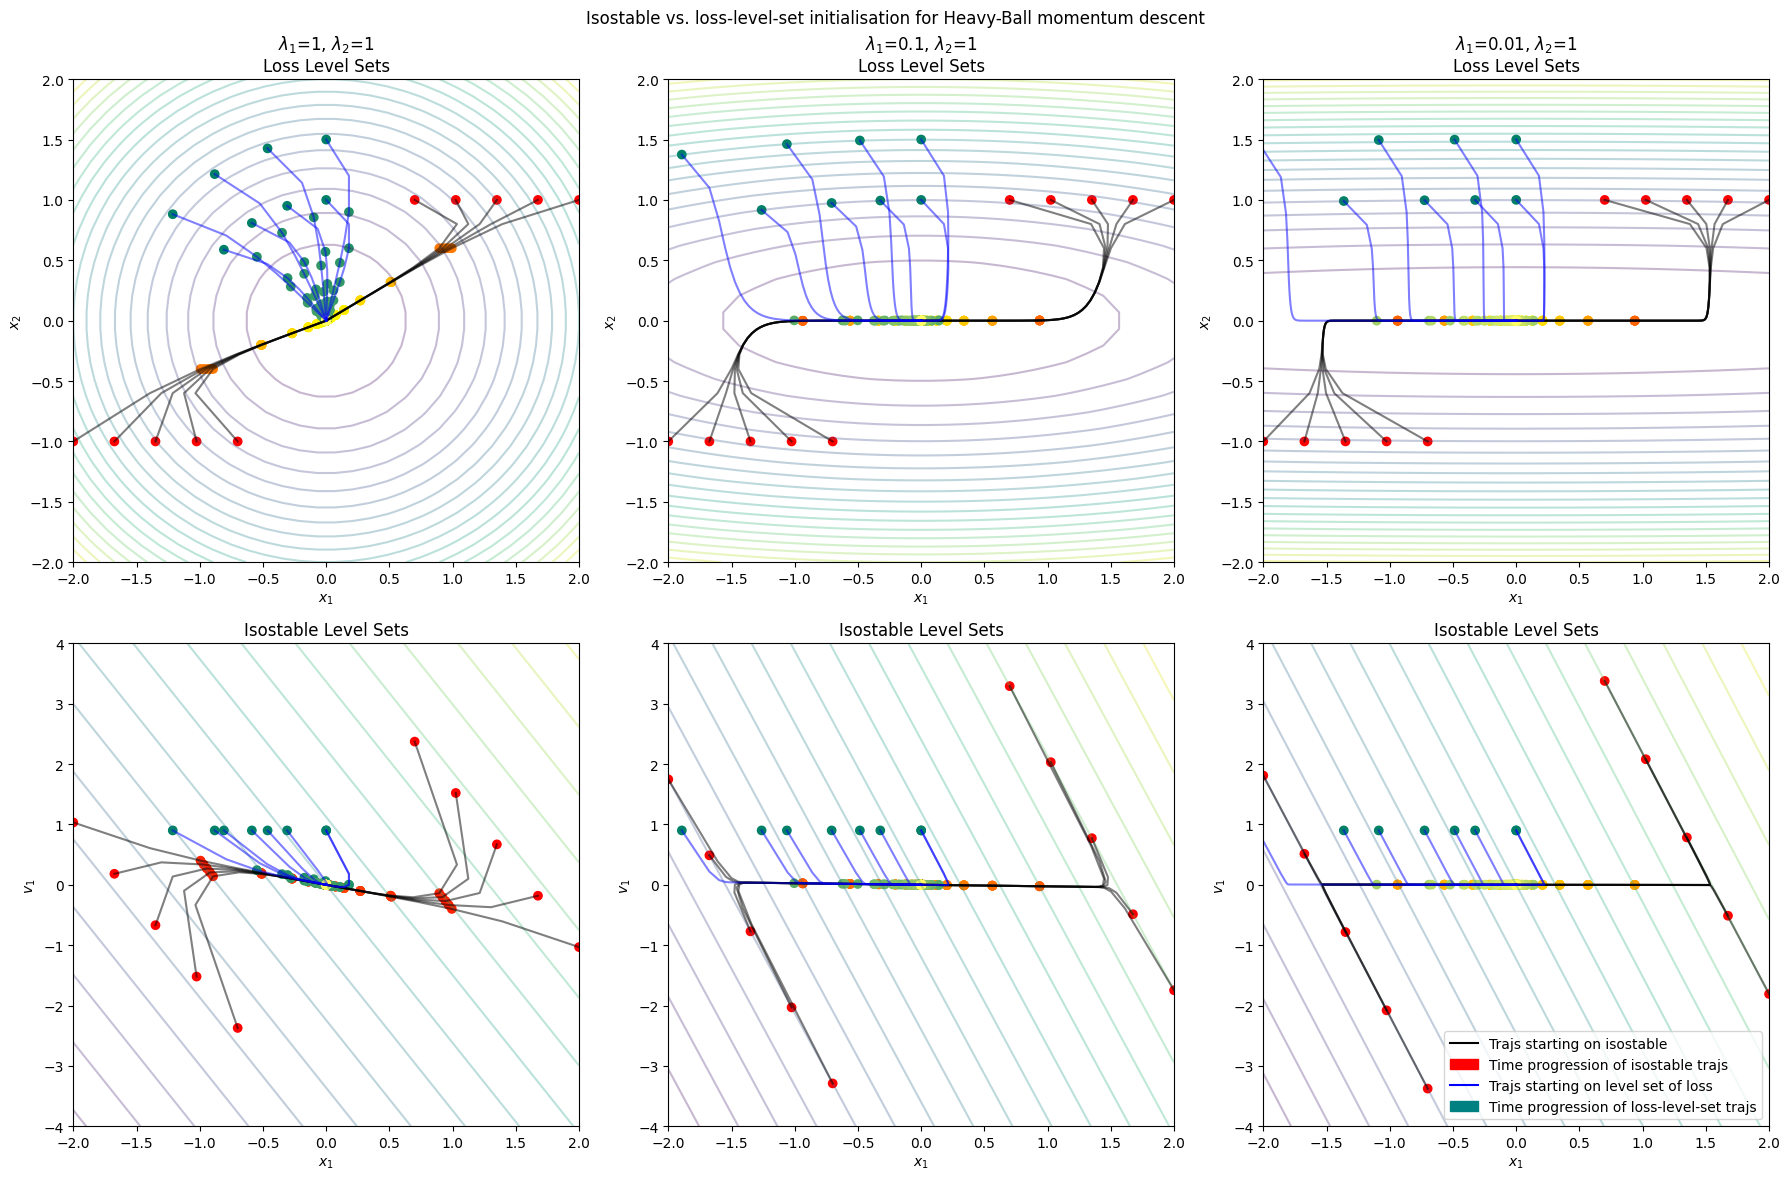

In [351]:
def heavy_ball_descent(S, grad_f, l1, l2, alpha, beta):
    x1, x2, v1, v2 = S
    X = np.array([x1, x2]).T
    V = np.array([v1, v2]).T

    V_prime = beta * V - alpha * grad_f(X, l1=l1, l2=l2)
    X_prime = X + V_prime
    return np.concatenate([X_prime, V_prime])

XMIN, XMAX = -2, 2
YMIN, YMAX = -2, 2
V1MIN, V1MAX = -4, 4
X1MIN, X1MAX = 0.7, 2
V1DEF = 0.9
V2DEF1, V2DEF0 = 1, 0
X2DEF = 1
PHIC = 1.5
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
for i, l1 in enumerate([1, 1e-1, 1e-2]):
    ax, ax2 = axes[:, i]
    alpha, beta, l2 = 0.1, 0.2, 1

    ## Level sets of loss
    step = 1
    x1_grid = np.linspace(XMIN, XMAX, 30)
    x2_grid = np.linspace(YMIN, YMAX, 30)
    X1, X2 = np.meshgrid(x1_grid, x2_grid)
    Loss = np.zeros_like(X1)
    for i in range(0, X1.shape[0], step):
        for j in range(0, X2.shape[1], step):
            X = X1[i, j], X2[i, j]
            Loss[i, j] = f(X, l1=l1, l2=l2)
    ax.contour(X1, X2, Loss, 20, cmap="viridis", alpha=0.3)

    # SANITY CHECK
    # A1 = np.array([[1-2*alpha*l1, beta], [-2*alpha*l1, beta]])
    # evals, evecs = np.linalg.eig(A1.T)
    # slow_eval = np.argmax(np.abs(evals))
    # w = evecs[:, slow_eval]
    # print("SLOW", evals, slow_eval, w)

    ## PLOTTING X1 vs V1
    # Isostables
    evals = eigenvalues(alpha, beta, l1)
    slow_eval = np.max(evals)
    # slow_evec = np.array([beta, slow_eval + 2 * alpha * l1 - 1])
    # slow_evec /= np.linalg.norm(slow_evec)
    w = np.array([slow_eval - beta, beta])
    w /= np.linalg.norm(w)

    def phi(x, v):
        return x * w[0] + v * w[1]

    # print("ISOSTABLE", evals, slow_eval, w)
    step = 1
    x1_grid = np.linspace(XMIN, XMAX, 30)
    v1_grid = np.linspace(V1MIN, V1MAX, 30)
    X1, V1 = np.meshgrid(x1_grid, v1_grid)
    Isostable = np.zeros_like(X1)
    for i in range(0, X1.shape[0], step):
        for j in range(0, V1.shape[1], step):
            x1, v1 = X1[i, j], V1[i, j]
            Isostable[i, j] = phi(x1, v1)
    ax2.contour(X1, V1, Isostable, 20, cmap="viridis", alpha=0.3)

    ## Trajectories starting on isostable
    n_timesteps = 5000
    skip_step = int(2 / l1)
    xs = np.linspace(X1MIN, X1MAX, 5)
    S0s = [np.array([x, X2DEF, (PHIC - x * w[0]) / w[1], V2DEF0]).T for x in xs]
    S0s.extend([np.array([-x, -X2DEF, -(PHIC - x * w[0]) / w[1], V2DEF1]).T for x in xs])
    for S0 in S0s:
        Xs = [S0]
        for t in range(n_timesteps - 1):
            Xt = heavy_ball_descent(
                Xs[-1], grad_f, l1=l1, l2=l2, alpha=alpha, beta=beta
            )
            Xs.append(Xt)
        Xs = np.array(Xs)
        phis = np.abs(Xs[:, 0] * w[0] + Xs[:, 2] * w[1])
        ax.plot(Xs[:, 0], Xs[:, 1], c="k", alpha=0.5)
        ax.scatter(
            Xs[::skip_step, 0],
            Xs[::skip_step, 1],
            c=-1
            * phis[
                ::skip_step
            ],  # [np.log(x / n_timesteps) for x in range(1, n_timesteps + 1, skip_step)],
            cmap="autumn",
        )

        ## PLOTTING X1 vs V1
        ax2.plot(Xs[:, 0], Xs[:, 2], c="k", alpha=0.5)
        ax2.scatter(
            Xs[::skip_step, 0],
            Xs[::skip_step, 2],
            c=[np.log(x / n_timesteps) for x in range(1, n_timesteps + 1, skip_step)],
            cmap="autumn",
        )

    # Trajectories starting on level set of loss
    thetas = np.linspace(np.pi / 2, 0.8 * np.pi, 4)
    X0s = [
        np.array(
            [
                np.sqrt(1 / (l1 * np.cos(theta) ** 2 + l2 * np.sin(theta) ** 2))
                * np.cos(theta),
                np.sqrt(1 / (l1 * np.cos(theta) ** 2 + l2 * np.sin(theta) ** 2))
                * np.sin(theta),
                V1DEF,
                V2DEF0,
            ]
        ).T
        for theta in thetas
    ]
    X0s.extend([np.array([1.5, 1.5, 1, 1]) * x for x in X0s])
    for X0 in X0s:
        Xs = [X0]
        for t in range(n_timesteps - 1):
            Xt = heavy_ball_descent(
                Xs[-1], grad_f, l1=l1, l2=l2, alpha=alpha, beta=beta
            )
            Xs.append(Xt)
        Xs = np.array(Xs)
        ax.plot(Xs[:, 0], Xs[:, 1], c="b", alpha=0.5)
        ax.scatter(
            Xs[::skip_step, 0],
            Xs[::skip_step, 1],
            c=[np.log(x / n_timesteps) for x in range(1, n_timesteps + 1, skip_step)],
            cmap="summer",
        )

        ## PLOTTING X1 vs V1
        ax2.plot(Xs[:, 0], Xs[:, 2], c="b", alpha=0.5)
        ax2.scatter(
            Xs[::skip_step, 0],
            Xs[::skip_step, 2],
            c=[np.log(x / n_timesteps) for x in range(1, n_timesteps + 1, skip_step)],
            cmap="summer",
        )

    ax.set_xlim((XMIN, XMAX))
    ax.set_ylim((YMIN, YMAX))
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    ax.set_title(f"$λ_1$={l1}, $λ_2$={l2}\nLoss Level Sets")

    ax2.set_xlim((XMIN, XMAX))
    # ax2.set_ylim((-5, 5))
    ax2.set_xlabel("$x_1$")
    ax2.set_ylabel("$v_1$")
    ax2.set_title("Isostable Level Sets")


iso_line = Line2D([0], [0], label="Trajs starting on isostable", c="k")
iso_patch = mpatches.Patch(color="red", label="Time progression of isostable trajs")
ls_line = Line2D([0], [0], label="Trajs starting on level set of loss", c="b")
ls_patch = mpatches.Patch(
    color="teal", label="Time progression of loss-level-set trajs"
)
plt.legend(handles=[iso_line, iso_patch, ls_line, ls_patch], loc="lower right")

plt.suptitle(
    "Isostable vs. loss-level-set initialisation for Heavy-Ball momentum descent"
)
plt.tight_layout()
plt.show()


In [443]:
from matplotlib.animation import FuncAnimation

XMIN, XMAX = -4, 4
YMIN, YMAX = -4, 4

all_trajs = []
XMIN, XMAX = -2, 2
YMIN, YMAX = -2, 2
V1MIN, V1MAX = -4, 4
X1MIN, X1MAX = 0.7, 2
V1DEF = 0.9
V2DEF1, V2DEF0 = 1, 0
X2DEF = 1
PHIC = 1.5
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
for i, l1 in enumerate([1, 1e-1, 1e-2]):
    ax, ax2 = axes[:, i]
    alpha, beta, l2 = 0.1, 0.2, 1

    ## Level sets of loss
    step = 1
    x1_grid = np.linspace(XMIN, XMAX, 30)
    x2_grid = np.linspace(YMIN, YMAX, 30)
    X1, X2 = np.meshgrid(x1_grid, x2_grid)
    Loss = np.zeros_like(X1)
    for i in range(0, X1.shape[0], step):
        for j in range(0, X2.shape[1], step):
            X = X1[i, j], X2[i, j]
            Loss[i, j] = f(X, l1=l1, l2=l2)
    ax.contour(X1, X2, Loss, 20, cmap="viridis", alpha=0.3)

    # SANITY CHECK
    # A1 = np.array([[1-2*alpha*l1, beta], [-2*alpha*l1, beta]])
    # evals, evecs = np.linalg.eig(A1.T)
    # slow_eval = np.argmax(np.abs(evals))
    # w = evecs[:, slow_eval]
    # print("SLOW", evals, slow_eval, w)

    ## PLOTTING X1 vs V1
    # Isostables
    evals = eigenvalues(alpha, beta, l1)
    slow_eval = np.max(evals)
    # slow_evec = np.array([beta, slow_eval + 2 * alpha * l1 - 1])
    # slow_evec /= np.linalg.norm(slow_evec)
    w = np.array([slow_eval - beta, beta])
    w /= np.linalg.norm(w)

    def phi(x, v):
        return x * w[0] + v * w[1]

    # print("ISOSTABLE", evals, slow_eval, w)
    step = 1
    x1_grid = np.linspace(XMIN, XMAX, 30)
    v1_grid = np.linspace(V1MIN, V1MAX, 30)
    X1, V1 = np.meshgrid(x1_grid, v1_grid)
    Isostable = np.zeros_like(X1)
    for i in range(0, X1.shape[0], step):
        for j in range(0, V1.shape[1], step):
            x1, v1 = X1[i, j], V1[i, j]
            Isostable[i, j] = phi(x1, v1)
    ax2.contour(X1, V1, Isostable, 20, cmap="viridis", alpha=0.3)

    ## Trajectories starting on isostable
    n_timesteps = 5000
    skip_step = int(2 / l1)
    xs = np.linspace(X1MIN, X1MAX, 5)
    S0s = [np.array([x, X2DEF, (PHIC - x * w[0]) / w[1], V2DEF0]).T for x in xs]
    S0s.extend([np.array([-x, -X2DEF, -(PHIC - x * w[0]) / w[1], V2DEF1]).T for x in xs])
    trajectories = []
    for S0 in S0s:
        Xs = [S0]
        for t in range(n_timesteps - 1):
            Xt = heavy_ball_descent(
                Xs[-1], grad_f, l1=l1, l2=l2, alpha=alpha, beta=beta
            )
            Xs.append(Xt)
        Xs = np.array(Xs)
        phis = np.abs(Xs[:, 0] * w[0] + Xs[:, 2] * w[1])
        ax.plot(Xs[:, 0], Xs[:, 1], c="k", alpha=0.5)
        # ax.scatter(
        #     Xs[::skip_step, 0],
        #     Xs[::skip_step, 1],
        #     c=-1
        #     * phis[
        #         ::skip_step
        #     ],  # [np.log(x / n_timesteps) for x in range(1, n_timesteps + 1, skip_step)],
        #     cmap="autumn",
        # )
        trajectories.append(Xs)
        ## PLOTTING X1 vs V1
        ax2.plot(Xs[:, 0], Xs[:, 2], c="k", alpha=0.5)
        
    all_trajs.append(trajectories)

        # ax2.scatter(
        #     Xs[::skip_step, 0],
        #     Xs[::skip_step, 2],
        #     c=[np.log(x / n_timesteps) for x in range(1, n_timesteps + 1, skip_step)],
        #     cmap="autumn",
        # )

    # # Trajectories starting on level set of loss
    # thetas = np.linspace(np.pi / 2, 0.8 * np.pi, 4)
    # X0s = [
    #     np.array(
    #         [
    #             np.sqrt(1 / (l1 * np.cos(theta) ** 2 + l2 * np.sin(theta) ** 2))
    #             * np.cos(theta),
    #             np.sqrt(1 / (l1 * np.cos(theta) ** 2 + l2 * np.sin(theta) ** 2))
    #             * np.sin(theta),
    #             V1DEF,
    #             V2DEF0,
    #         ]
    #     ).T
    #     for theta in thetas
    # ]
    # X0s.extend([np.array([1.5, 1.5, 1, 1]) * x for x in X0s])
    # for X0 in X0s:
    #     Xs = [X0]
    #     for t in range(n_timesteps - 1):
    #         Xt = heavy_ball_descent(
    #             Xs[-1], grad_f, l1=l1, l2=l2, alpha=alpha, beta=beta
    #         )
    #         Xs.append(Xt)
    #     Xs = np.array(Xs)
    #     ax.plot(Xs[:, 0], Xs[:, 1], c="b", alpha=0.5)
    #     ax.scatter(
    #         Xs[::skip_step, 0],
    #         Xs[::skip_step, 1],
    #         c=[np.log(x / n_timesteps) for x in range(1, n_timesteps + 1, skip_step)],
    #         cmap="summer",
    #     )

    #     ## PLOTTING X1 vs V1
    #     ax2.plot(Xs[:, 0], Xs[:, 2], c="b", alpha=0.5)
    #     ax2.scatter(
    #         Xs[::skip_step, 0],
    #         Xs[::skip_step, 2],
    #         c=[np.log(x / n_timesteps) for x in range(1, n_timesteps + 1, skip_step)],
    #         cmap="summer",
    #     )

    ax.set_xlim((XMIN, XMAX))
    ax.set_ylim((YMIN, YMAX))
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    ax.set_title(f"$λ_1$={l1}, $λ_2$={l2}\nLoss Level Sets")

    ax2.set_xlim((XMIN, XMAX))
    # ax2.set_ylim((-5, 5))
    ax2.set_xlabel("$x_1$")
    ax2.set_ylabel("$v_1$")
    ax2.set_title("Isostable Level Sets")


all_points = [ax.scatter([], [], s=25, c="black") for axs in axes for ax in axs]
print(all_points)
print(len(all_trajs))
def update(frame):
    for i, trajectories in enumerate(all_trajs):
        points1 = all_points[i]
        xs = [traj[frame, 0] for traj in trajectories]
        ys = [traj[frame, 1] for traj in trajectories]
        points1.set_offsets(np.column_stack([xs, ys]))

        points2 = all_points[i+3]
        xs = [traj[frame, 0] for traj in trajectories]
        ys = [traj[frame, 2] for traj in trajectories]
        points2.set_offsets(np.column_stack([xs, ys]))
    return all_points


ani = FuncAnimation(fig, update, frames=frames, interval=100, blit=True)
plt.suptitle("Heavy ball descent trajectories starting on isostable")
plt.tight_layout()
ani.save("quad-loss-heavy-ball_isostable_convergence.gif", writer="pillow", fps=40)
plt.close()

[<matplotlib.collections.PathCollection object at 0x2a14860d0>, <matplotlib.collections.PathCollection object at 0x2a1486210>, <matplotlib.collections.PathCollection object at 0x2a1486350>, <matplotlib.collections.PathCollection object at 0x2a1486490>, <matplotlib.collections.PathCollection object at 0x2a14865d0>, <matplotlib.collections.PathCollection object at 0x2a1486710>]
3


## Part C: Experiments and comparison
Choose representative parameter values and run both algorithms from multiple random initial conditions in a box $x_0 \sim \operatorname{Unif}([-2,2]^2).$

Parameter values:

$\lambda_1 \in \{1, 0.1, 0.01, 0.001\}$

$\lambda_2 \in \{1\}$

$\alpha \in \{1, 0.1, 0.05, 0.01\}$

$\beta \in \{0.5, 0.2, 0.1, 0.05, 0.01\}$


#### a) Compare convergence of $f(x_k)$ vs. iteration $k$.

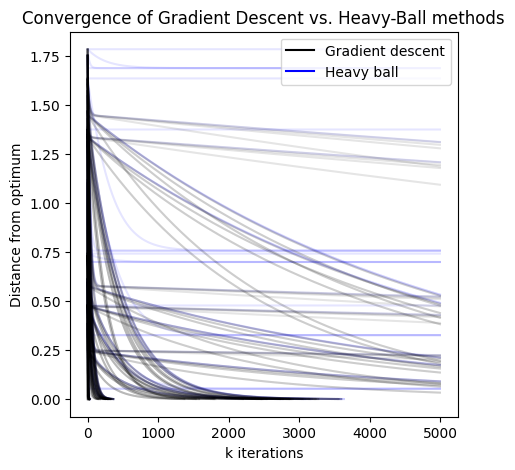

In [379]:
def run_until_convergence(S0, alg, grad_f, atol=0.01, max_steps=1000):
    St = S0
    convergences, iterations = [], []
    for t in range(max_steps - 1):
        St = alg(St, grad_f)
        convergence = np.linalg.norm(St[:2])
        convergences.append(convergence)
        iterations.append(t)
        if  convergence < atol:
            break
    return convergences, iterations
    
    
n_samples = 5

l1s = [1, 0.1, 0.01, 0.001]
l2s = [1]
alphas = [1, 0.1, 0.01]
betas = [0.5, 0.2, 0.1, 0.01]
X0s = 4 * np.random.rand(n_samples, 2) - 2
V0 = np.array([0, 0]).T

atol = 0.001
max_steps = 5000

GD_convergences = []
HB_convergences = []
for X0 in X0s:
    for l1 in l1s:
        for l2 in l2s:
            for alpha in alphas:
                GD_convergs, GD_iters = run_until_convergence(X0, lambda X, grad_f: grad_descent(X, grad_f=grad_f, l1=l1, l2=l2, alpha=alpha), grad_f=grad_f, atol=atol, max_steps=max_steps)
                GD_convergences.append((GD_convergs, GD_iters))
                
                for beta in betas:
                    S0 = np.concatenate([X0.T, V0])

                    HB_convergs, HB_iters = run_until_convergence(S0, lambda S, grad_f: heavy_ball_descent(S, grad_f=grad_f, l1=l1, l2=l2, alpha=alpha, beta=beta), grad_f=grad_f, atol=atol, max_steps=max_steps)
                    HB_convergences.append((HB_convergs, HB_iters))

fig, ax = plt.subplots(1, 1, figsize=(5,5))
for convergs, iters in GD_convergences:
    ax.plot(iters, convergs, c="b", alpha=0.1)
for convergs, iters in HB_convergences:
    ax.plot(iters, convergs, c="k", alpha=0.1)

ax.set_xlabel("k iterations")
ax.set_ylabel("Distance from optimum")

gd_line = Line2D([0], [0], label="Gradient descent", c="k")
hb_line = Line2D([0], [0], label="Heavy ball", c="b")
plt.legend(handles=[gd_line, hb_line], loc="upper right")

plt.title("Convergence of Gradient Descent vs. Heavy-Ball methods")
plt.show()


#### b) Compare $||\nabla f(x_k)||$ vs. iteration k.

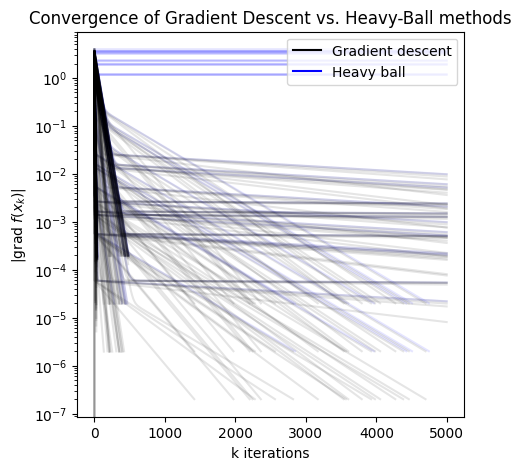

In [387]:
def run_until_convergence_give_grads(S0, alg, grad_f, l1, l2, atol=0.01, max_steps=1000):
    St = S0
    convergences, iterations = [], []
    for t in range(max_steps - 1):
        St = alg(St, grad_f)
        convergence = np.linalg.norm(St[:2])
        mag_grad = np.linalg.norm(grad_f(St[:2], l1=l1, l2=l2))
        convergences.append(mag_grad)
        iterations.append(t)
        if  convergence < atol:
            break
    return convergences, iterations
    
    
n_samples = 5

l1s = [1, 0.1, 0.01, 0.001]
l2s = [1]
alphas = [1, 0.1, 0.01]
betas = [0.5, 0.2, 0.1, 0.01]
X0s = 4 * np.random.rand(n_samples, 2) - 2
V0 = np.array([0, 0]).T

atol = 0.0001
max_steps = 5000

GD_convergences = []
HB_convergences = []
for X0 in X0s:
    for l1 in l1s:
        for l2 in l2s:
            for alpha in alphas:
                GD_convergs, GD_iters = run_until_convergence_give_grads(X0, lambda X, grad_f: grad_descent(X, grad_f=grad_f, l1=l1, l2=l2, alpha=alpha), grad_f=grad_f, l1=l1, l2=l2, atol=atol, max_steps=max_steps)
                GD_convergences.append((GD_convergs, GD_iters))
                
                for beta in betas:
                    S0 = np.concatenate([X0.T, V0])

                    HB_convergs, HB_iters = run_until_convergence_give_grads(S0, lambda S, grad_f: heavy_ball_descent(S, grad_f=grad_f, l1=l1, l2=l2, alpha=alpha, beta=beta), grad_f=grad_f, l1=l1, l2=l2, atol=atol, max_steps=max_steps)
                    HB_convergences.append((HB_convergs, HB_iters))

fig, ax = plt.subplots(1, 1, figsize=(5,5))
for convergs, iters in GD_convergences:
    ax.plot(iters, convergs, c="b", alpha=0.1)
for convergs, iters in HB_convergences:
    ax.plot(iters, convergs, c="k", alpha=0.1)

ax.set_xlabel("k iterations")
ax.set_ylabel("|grad $f(x_k)$|")
ax.set_yscale("log")

gd_line = Line2D([0], [0], label="Gradient descent", c="k")
hb_line = Line2D([0], [0], label="Heavy ball", c="b")
plt.legend(handles=[gd_line, hb_line], loc="upper right")

plt.title("Convergence of Gradient Descent vs. Heavy-Ball methods")
plt.show()


#### c) Compare number of iterations to reach convergence for various atols.

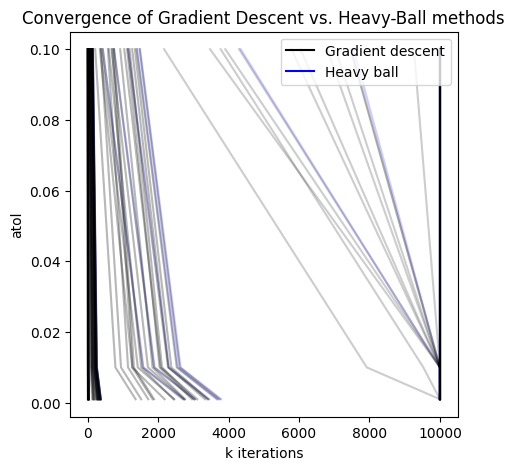

In [390]:
n_samples = 5

l1s = [1, 0.1, 0.01, 0.001]
l2s = [1]
alphas = [1, 0.1, 0.01]
betas = [0.5, 0.2, 0.1, 0.01]
X0s = 4 * np.random.rand(n_samples, 2) - 2
V0 = np.array([0, 0]).T

atols = [0.1, 0.01, 0.001]
max_steps = 10000

GD_n_iters = []
HB_n_iters = []

for X0 in X0s:
    for l1 in l1s:
        for l2 in l2s:
            for alpha in alphas:
                these_iters = []
                for atol in atols:
                    GD_convergs, GD_iters = run_until_convergence(X0, lambda X, grad_f: grad_descent(X, grad_f=grad_f, l1=l1, l2=l2, alpha=alpha), grad_f=grad_f, atol=atol, max_steps=max_steps)
                    these_iters.append(len(GD_iters))
                GD_n_iters.append(these_iters)
                
                for beta in betas:
                    S0 = np.concatenate([X0.T, V0])
                    these_iters = []
                    for atol in atols:
                        HB_convergs, HB_iters = run_until_convergence(S0, lambda S, grad_f: heavy_ball_descent(S, grad_f=grad_f, l1=l1, l2=l2, alpha=alpha, beta=beta), grad_f=grad_f, atol=atol, max_steps=max_steps)
                        these_iters.append(len(HB_iters))
                    HB_n_iters.append(these_iters)

fig, ax = plt.subplots(1, 1, figsize=(5,5))
for iters in GD_n_iters:
    ax.plot(iters, atols, c="b", alpha=0.1)
for iters in HB_n_iters:
    ax.plot(iters, atols, c="k", alpha=0.1)

ax.set_xlabel("k iterations")
ax.set_ylabel("atol")

gd_line = Line2D([0], [0], label="Gradient descent", c="k")
hb_line = Line2D([0], [0], label="Heavy ball", c="b")
plt.legend(handles=[gd_line, hb_line], loc="upper right")

plt.title("Convergence of Gradient Descent vs. Heavy-Ball methods")
plt.show()
